In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tqdm import tqdm
import skimage
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
def get_mask_data():

    x_train_path = "dataset/Infection/mask_infection.npy"
    x_val_path = "dataset/Infection/mask_infection_val.npy"
    x_test_path = "dataset/Infection/mask_infection_test.npy"
    y_train_path = "dataset/Infection/y_train3.npy"
    y_val_path = "dataset/Infection/y_val3.npy"
    y_test_path = "dataset/Infection/y_test3.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    x_test = np.load(x_test_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)
    y_test = np.load(y_test_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    print(x_test.shape, y_test.shape)
    
        
    return x_train, x_val, x_test, y_train, y_val, y_test


In [3]:
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.MeanIoU(num_classes=3)])

    model.summary()
    
    
    

    return model

In [4]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')

#     predic = model.predict(x_val)

#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
#         ax[i, 0].title.set_text(str(i))
#         ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
#         ax[i, 2].imshow(predic[i].squeeze(), cmap='gray')
        
        
#         temp = x_val[i]
#         pred_sum = predic[i][predic[i] > 0]
#         pred_mean = np.mean(pred_sum)
#         if(np.min(x_val[i]) >= 0) :
#             predic[i] = (predic[i]/ np.max(predic[i])) * 255
#             temp = cv2.add(temp, predic[i])
#         else :
#             predic[i] = (predic[i]/ np.max(predic[i])) * 2048
#             temp = cv2.add(temp, predic[i])
#         ax[i, 3].imshow(temp.squeeze(), cmap='Reds')
#         temp = x_val[i]
#         pred_sum = preds[i][preds[i] > 0]
#         pred_mean = np.mean(pred_sum)
#         if(np.min(temp) >= 0) :
#             temp[preds[i] < pred_mean] = 0
#         else :
#             temp[preds[i] < pred_mean] = -2048
#         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_1[0][

Epoch 1/30
149/149 [==============================] - 83s 488ms/step - loss: 0.5302 - acc: 0.9413 - mean_io_u: 0.2505 - val_loss: 0.4047 - val_acc: 0.9668 - val_mean_io_u: 0.2500
Epoch 2/30
149/149 [==============================] - 66s 444ms/step - loss: 0.2076 - acc: 0.9890 - mean_io_u: 0.2512 - val_loss: 0.1724 - val_acc: 0.9856 - val_mean_io_u: 0.2500
Epoch 3/30
149/149 [==============================] - 66s 441ms/step - loss: 0.0847 - acc: 0.9901 - mean_io_u: 0.2509 - val_loss: 0.0859 - val_acc: 0.9867 - val_mean_io_u: 0.2508
Epoch 4/30
149/149 [==============================] - 66s 444ms/step - loss: 0.0499 - acc: 0.9909 - mean_io_u: 0.2509 - val_loss: 0.0592 - val_acc: 0.9861 - val_mean_io_u: 0.2500
Epoch 5/30
149/149 [==============================] - 66s 445ms/step - loss: 0.0352 - acc: 0.9921 - mean_io_u: 0.2508 - val_loss: 0.0732 - val_acc: 0.9787 - val_mean_io_u: 0.2514
Epoch 6/30
149/149 [==============================] - 66s 445ms/step - loss: 0.0309 - acc: 0.9920 - mean_

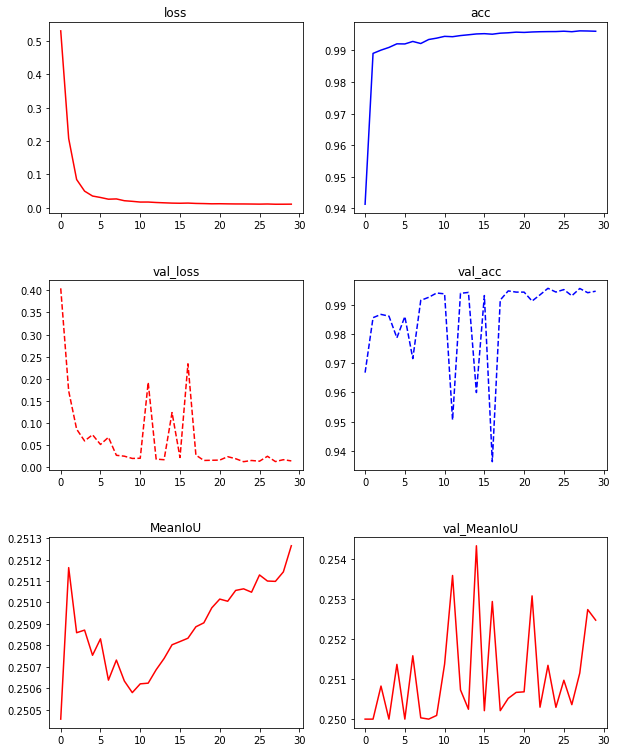

In [5]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
model = VGG16_Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)


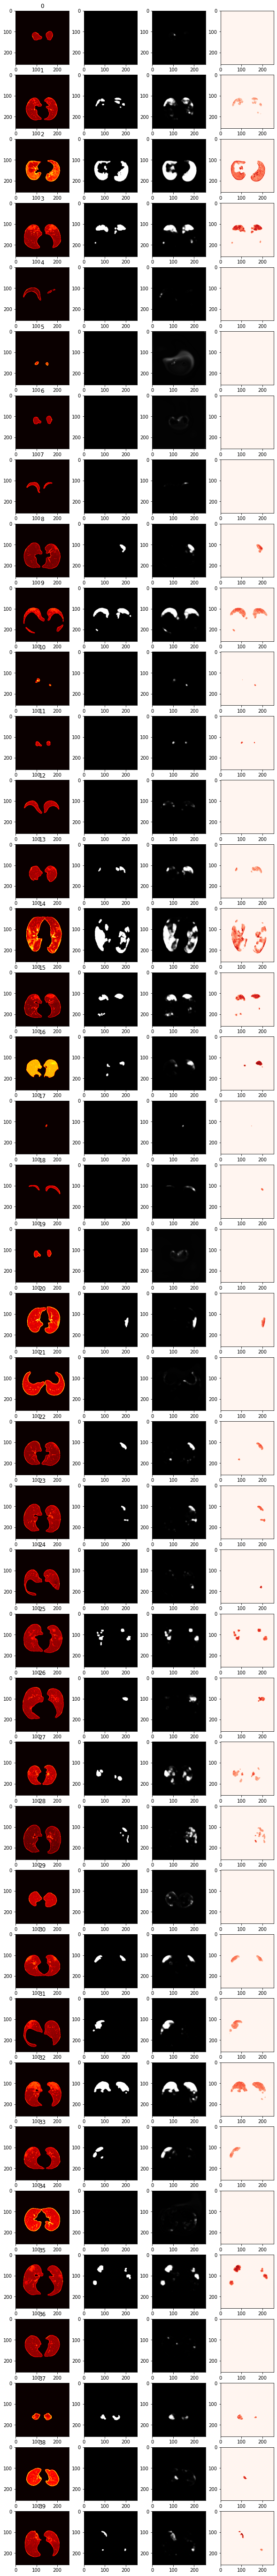

In [6]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
predic = model.predict(x_val)

fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

y = y_val[...,0]
predic_0 = predic[...,0]
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
    ax[i, 0].title.set_text(str(i))
    ax[i, 1].imshow(y[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(predic_0[i].squeeze(), cmap='gray')
        
        
    temp = x_val[i]
    temp[predic_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='Reds')

In [8]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = predic[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output index번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if y_label_image[i][j] == 1 or predict_image[i][j] == 1:
                if y_label_image[i][j] == 1 and predict_image[i][j] == 1:
                    TP = TP + 1
                else :
                    NP = NP + 1
            
    if TP == 0 and NP == 0 : 
        TP = 1
    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image + 1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 1 NP :  0
IOU : 1.0 

Number :  1 TP : 1125 NP :  825
IOU : 0.5769230769230769 

Number :  2 TP : 6495 NP :  1188
IOU : 0.8453729012104647 

Number :  3 TP : 2375 NP :  507
IOU : 0.8240804996530188 

Number :  4 TP : 1 NP :  0
IOU : 1.0 

Number :  5 TP : 1 NP :  0
IOU : 1.0 

Number :  6 TP : 1 NP :  0
IOU : 1.0 

Number :  7 TP : 1 NP :  0
IOU : 1.0 

Number :  8 TP : 538 NP :  153
IOU : 0.7785817655571635 

Number :  9 TP : 3042 NP :  761
IOU : 0.7998948198790429 

Number :  10 TP : 0 NP :  49
IOU : 0.0 

Number :  11 TP : 0 NP :  92
IOU : 0.0 

Number :  12 TP : 1 NP :  0
IOU : 1.0 

Number :  13 TP : 731 NP :  384
IOU : 0.6556053811659193 

Number :  14 TP : 7175 NP :  2260
IOU : 0.7604663487016429 

Number :  15 TP : 1711 NP :  447
IOU : 0.7928637627432809 

Number :  16 TP : 362 NP :  386
IOU : 0.4839572192513369 

Number :  17 TP : 0 NP :  7
IOU : 0.0 

Number :  18 TP : 0 NP :  94
IOU : 0.0 

Number :  19 TP : 1 NP :  0
IOU : 1.0 

Number :  20 TP : 506 NP :  

Number :  157 TP : 2940 NP :  2231
IOU : 0.5685554051440728 

Number :  158 TP : 2263 NP :  490
IOU : 0.8220123501634581 

Number :  159 TP : 1 NP :  0
IOU : 1.0 

Number :  160 TP : 0 NP :  59
IOU : 0.0 

Number :  161 TP : 528 NP :  269
IOU : 0.6624843161856964 

Number :  162 TP : 0 NP :  8
IOU : 0.0 

Number :  163 TP : 1030 NP :  143
IOU : 0.8780903665814151 

Number :  164 TP : 0 NP :  35
IOU : 0.0 

Number :  165 TP : 2359 NP :  1000
IOU : 0.7022923489133671 

Number :  166 TP : 1755 NP :  581
IOU : 0.7512842465753424 

Number :  167 TP : 111 NP :  342
IOU : 0.24503311258278146 

Number :  168 TP : 599 NP :  182
IOU : 0.7669654289372599 

Number :  169 TP : 1 NP :  0
IOU : 1.0 

Number :  170 TP : 1121 NP :  281
IOU : 0.7995720399429387 

Number :  171 TP : 0 NP :  55
IOU : 0.0 

Number :  172 TP : 1 NP :  0
IOU : 1.0 

Number :  173 TP : 1 NP :  0
IOU : 1.0 

Number :  174 TP : 1559 NP :  875
IOU : 0.6405094494658997 

Number :  175 TP : 200 NP :  1198
IOU : 0.1430615164520744 